In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch

from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# If running on Apple Silicon or CUDA is available, use the GPU.

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

### Data loading and preprocessing for training
In this notebook, we will load and preprocess the data generated with the notebook `data_generation.ipynb` and saved as `data/training_dataset.pkl`.

In [3]:
# Get the absolute path of the directory where the notebook is located
print("Current working directory", os.getcwd())
data_folder = os.path.join(os.getcwd(), 'genAI-Days/01_normalizing_flows/data')
file_name = os.path.join(data_folder, 'dataset.pkl')

if not os.path.isfile(file_name):
    raise ValueError(f"File {file_name} does not exist, correct path or generate data set.")

with open(file_name, 'rb') as f:
    data = pickle.load(f)
print('Sucessfully loaded dataset with', len(data['hp']), 'waveforms.')

Current working directory /Users/akofler/Desktop/courses_and_tutorials/2024_genAI_days_ODSL
Sucessfully loaded dataset with 10000 waveforms.


In [4]:
hp, hc = data['hp'], data['hc']
parameters = data['masses']
f_min, f_max, T = data['f_min'], data['f_max'], data['T']
delta_f = 1/T

Standardize masses for training

In [5]:
parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std

Pre-process waveforms: 
- truncate below f_min
- re-package real and imaginary part
- only use $h_+$ for simplicity

In [6]:
lower_cut = int(f_min / delta_f)
waveforms = np.hstack((hp.real[:, lower_cut:], hc.imag[:, lower_cut:])).astype(np.float32)

Wrap waveforms with pytorch Dataset

In [7]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms):
        self.parameters = parameters
        self.waveforms = waveforms

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = np.random.normal(size = signal.shape).astype(np.float32)
        data = signal + noise
        if device == "mps":
            return torch.tensor(data, dtype=torch.float32, device=device), torch.tensor(params,  dtype=torch.float32, device=device)
        else:
            return torch.tensor(data, device=device), torch.tensor(params, device=device)
    
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

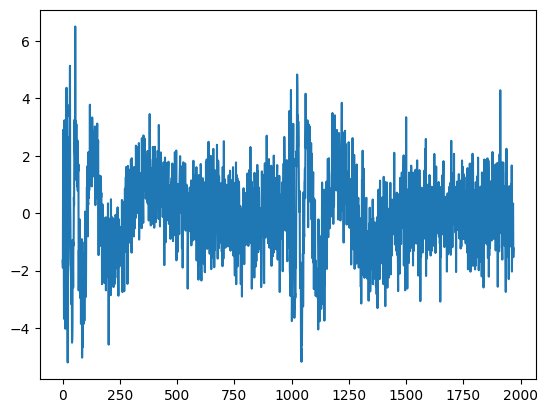

In [8]:
# Get first sample
signal, params = waveform_dataset[0]
signal = signal.cpu()  # Careful to put data back onto CPU.
# Plot signal
plt.plot(signal)
plt.show()

### Split data into train and test dataset

In [9]:
# Split the dataset into training and test sets
num_samples = len(waveform_dataset)
train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Conditional Normalizing Flow

### Training

### Visualize posteriors

In [10]:
# num_posteriors = 5
# num_eval_samples = 10000

# model.eval()

# for n in range(num_posteriors):

#     with torch.no_grad():
    
#         test_x, test_y = test_dataset[n]
       
#         # Sample the posterior
#         test_x = test_x.expand(num_eval_samples, *x.shape)
#         pred_samples = model.sample(1, test_x).squeeze(1).cpu().numpy()
    
#         # Undo the standardization
#         pred_samples = parameters_std * pred_samples + parameters_mean
#         truth = parameters_std * test_y.cpu().numpy() + parameters_mean
    
#         # Plot
#         corner.corner(pred_samples, truths=truth, labels=['$M_c$', '$q$'])
#         plt.show()

### Tasks:
- It is often easier to learn a posterior that is not defined by the masses $m_1, m_2$ of the black holes directly, but by the chirp mass $\mathcal{M} = \frac{(m_1 \cdot m_2)^{3/5}}{(m_1 + m_2)^{1/5}}$ and mass ratio $q = \frac{m_2}{m_1}$. Re-define the input parameters and compare whether this improves training.
- 